In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
x_data_simulated = np.random.randn(1000, 49)
params = np.random.randn(50)
#add a column of ones to x_data_simulated
x_data_simulated = np.hstack((np.ones((1000, 1)), x_data_simulated))
y_data_simulated = x_data_simulated @ params + np.random.randn(1000) * 0.5


In [3]:
#fit the lasso model with fixed lambda
alpha = 2
lasso = LassoCV(alphas=[alpha], cv=5).fit(x_data_simulated, y_data_simulated)
# Get the coefficients
coefficients = lasso.coef_


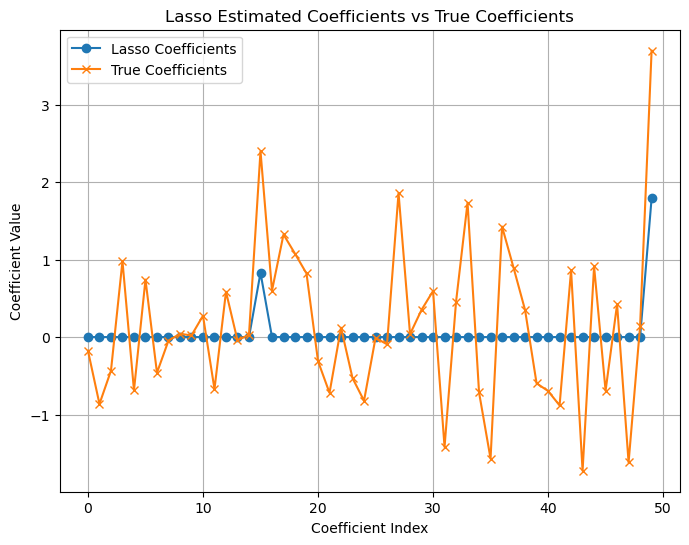

In [4]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(coefficients, marker='o')
ax.plot(params, marker='x')
ax.set_xlabel('Coefficient Index')
ax.set_ylabel('Coefficient Value')
ax.set_title('Lasso Estimated Coefficients vs True Coefficients')
ax.legend(['Lasso Coefficients', 'True Coefficients'])
plt.grid()
plt.show()

In [5]:
#check that the stage 2 works well
from stage2 import estimate_kappa_curve_fit
from scipy.optimize import curve_fit

#fix kappa
kappa = 0.8

#generate predictors for stage 2
pred = np.random.normal(size=1000)*0.01

#generate true y values (returns)
y = np.log(1 - kappa * np.exp(pred[:-1])) - np.log(1 - kappa * np.exp(pred[1:])) + np.random.normal(size=999)*10

#add a nan to first entry of y to match dimensions
y = np.insert(y, 0, np.nan)

stage2 = {}
stage2['vwretd'] = pd.Series(y)
stage2['predictions'] = pd.Series(pred)
kappa_estimated = estimate_kappa_curve_fit(stage2)
print(f"True kappa: {kappa}, Estimated kappa: {kappa_estimated}")

True kappa: 0.8, Estimated kappa: 0.9511562832526256


In [6]:
def model(x, kappa):
    pred_t, pred_t1 = x
    return np.log(1 - kappa * np.exp(pred_t)) - np.log(1 - kappa * np.exp(pred_t1))

initial_kappa = 0.8
bounds = (0, 1)

popt, _ = curve_fit(model, (pred[:-1], pred[1:]), y[1:],
                            p0=[initial_kappa], bounds=bounds)
estimated_kappa = popt[0]
print(f"True kappa: {kappa}, Estimated kappa (curve_fit): {estimated_kappa}")

#compute the r_squared of the fit
y_pred = model((pred[:-1], pred[1:]), estimated_kappa)
ss_res = np.sum((y[1:] - y_pred) ** 2)
ss_tot = np.sum((y[1:] - np.mean(y[1:])) ** 2)
r_squared = 1 - (ss_res / ss_tot)
print(f"R-squared of the fit: {r_squared}")


True kappa: 0.8, Estimated kappa (curve_fit): 0.9511562832526256
R-squared of the fit: -0.0005968482671312447


In [7]:
# Testing stage 1
import pandas as pd
import csv
import pickle
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
from pathlib import Path
import os

from stage1 import lasso_rolling_window, create_lagged_features, get_coefficient_dataframe, analyze_results
from stage2 import estimate_kappa

In [8]:
base_dir = Path(os.getenv("LASSO_OUTPUT_DIR", "output"))
features_path = Path("output") / "features.pkl"
response_path = Path("output") / "response.pkl"
return_path = Path("data") / "return84_20.csv"

with features_path.open("rb") as f:
    X = pickle.load(f)
    
with response_path.open("rb") as f:
    y = pickle.load(f)

if not return_path.exists():
    return_path = Path(r"C:\Users\jonat\Lasso_paper\Empirical\data\return84_20.csv")
    print("Using absolute path:", return_path)


Using absolute path: C:\Users\jonat\Lasso_paper\Empirical\data\return84_20.csv


In [9]:
#get the predictors
lags_number = 3
X_lagged, feature_names = create_lagged_features(X, lags_number, 0)

#create 540 vector of parameters (sparse)
number_of_non_zero = 10
betas = np.zeros(X_lagged.shape[1])
non_zero_indices = np.random.choice(X_lagged.shape[1], size=number_of_non_zero, replace=False)
betas[non_zero_indices] = np.random.randn(number_of_non_zero) * 0.5

#generate simulated y
y_simulated = X_lagged @ betas + np.random.randn(X_lagged.shape[0]) * 0.01

In [10]:
y_simulated.shape, X_lagged.shape, X.shape

((8436,), (8436, 540), (8439, 180))

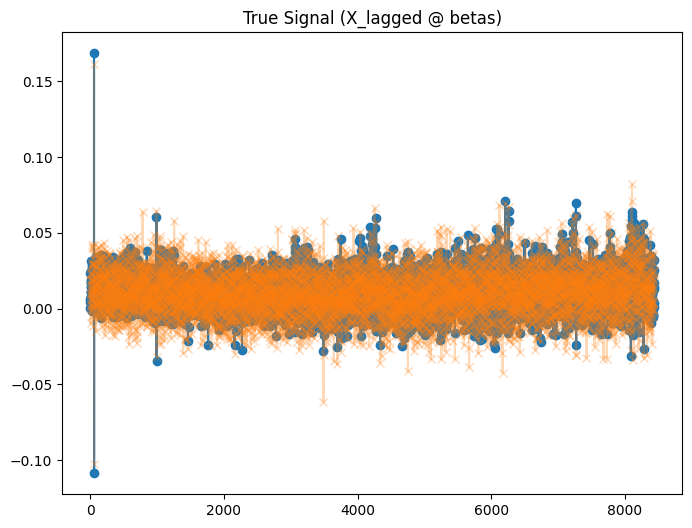

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(X_lagged @ betas, marker='o')
ax.plot(y_simulated, marker='x', label='True returns', alpha = 0.3)
ax.set_title('True Signal (X_lagged @ betas)')
plt.show()

In [12]:
# cv_folds = 5
# window_size = X_lagged.shape[0]
# lasso_est = LassoCV(cv=min(cv_folds, max(2, window_size // 2)),
#                                         max_iter=2000,
#                                         fit_intercept=False,
#                                         random_state=0)
# lasso_est.fit(X_lagged, y_simulated)

In [13]:
# # Testing with rolling windows
# window_size = 200
# n_windows = len(y_aligned) - window_size + 1
# for i in tqdm(range(0, n_windows), desc="Rolling windows"):
#         start_idx = max(0, i)
#         end_idx = start_idx + window_size

#         X_window = X_lagged[start_idx:end_idx]
#         y_window = y_aligned[start_idx:end_idx]

#         if standardize:
#             scaler = StandardScaler()
#             X_window_scaled = scaler.fit_transform(X_window)
#         else:
#             scaler = None
#             X_window_scaled = X_window


In [14]:
alpha = 0.002
window_size = 30
#add three nans to y_simulated to match dimensions
y_simulated = np.insert(y_simulated, 0, [np.nan]*3)
print(type(y_simulated))
lasso_results = lasso_rolling_window(X, y_simulated, window_size=window_size, n_lags = lags_number, lambda_mode = 'fixed', fixed_lambda=alpha)

<class 'numpy.ndarray'>
Creating lagged features with 3 lags...
Running 8407 rolling windows of size 30...
Lambda selection: fixed (alpha = 0.002).


Rolling windows: 100%|██████████| 8407/8407 [00:06<00:00, 1262.60it/s]

Rolling LASSO complete!
Average lambda: 0.002000


In [18]:
  # Step 2: Compute residuals
preds = np.array(lasso_results["predictions"]) 
y_valid = y_simulated[-len(preds):] if not isinstance(y_simulated, pd.Series) else y_simulated.iloc[-len(preds):]
u = y_valid.values - preds if isinstance(y_valid, pd.Series) else y_valid - preds

#compute r_squared
ss_total = np.sum((y_valid - np.mean(y_valid))**2)
ss_residual = np.sum(u**2)
r_squared = 1 - (ss_residual / ss_total)
print(f"R-squared of Lasso predictions: {r_squared}")

R-squared of Lasso predictions: -0.016485831019187325


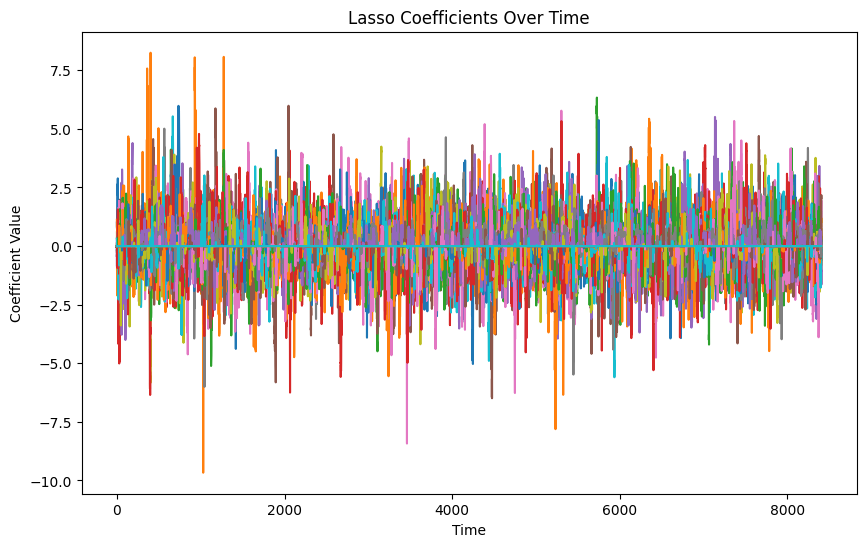

In [19]:
#visualize the coefficients over time
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(lasso_results['coefficients'].shape[1]):
    ax.plot(lasso_results['coefficients'][:, i], label=f'Coef {i}')
ax.set_title('Lasso Coefficients Over Time')
ax.set_xlabel('Time')
ax.set_ylabel('Coefficient Value')
plt.show()

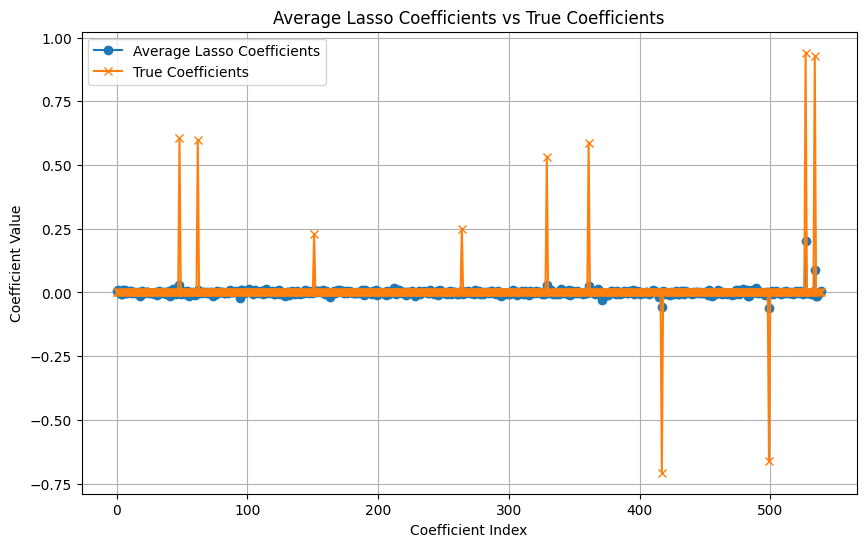

In [20]:
#visualize the parameters
lasso_coefs = lasso_results['coefficients']
#average beta over time
avg_coefs = np.mean(lasso_coefs, axis=0)
plt.figure(figsize=(10, 6))
plt.plot(avg_coefs, marker='o')
plt.plot(betas, marker='x')
plt.xlabel('Coefficient Index') 
plt.ylabel('Coefficient Value')
plt.title('Average Lasso Coefficients vs True Coefficients')
plt.legend(['Average Lasso Coefficients', 'True Coefficients'])
plt.grid()
plt.show()